In [1]:
import csv
import os
import random
import sys
from datetime import datetime
from pathlib import Path
from random import sample

import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable
from torch.distributions.kl import kl_divergence
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchvision.utils import save_image

In [2]:
path = "/Users/M283455/VAE_prject/scripts/"
sys.path.insert(0, path)

In [3]:
import VAE_tybalt
from VAE_tybalt import VAE

In [4]:
# This is normalized TCGA data from Tybalt github
tcga_tybalt_file_location = "../data/raw/pancan_scaled_zeroone_rnaseq.tsv.gz"

In [5]:
tcga_rnaseq_df = pd.read_table(tcga_tybalt_file_location)
tcga_rnaseq_df.drop(columns=tcga_rnaseq_df.columns[0], axis=1, inplace=True)
tcga_rnaseq_df = tcga_rnaseq_df.dropna()
print(tcga_rnaseq_df.shape)
tcga_rnaseq_df.head(2)

(10459, 5000)


,RPS4Y1,XIST,KRT5,AGR2,CEACAM5,KRT6A,KRT14,CEACAM6,DDX3Y,KDM5D,...,FAM129A,C8orf48,CDK5R1,FAM81A,C13orf18,GDPD3,SMAGP,C2orf85,POU5F1B,CHST2
0,0.678296,0.289910,0.034230,0.0,0.0,0.084731,0.031863,0.037709,0.746797,0.687833,...,0.440610,0.428782,0.732819,0.634340,0.580662,0.294313,0.458134,0.478219,0.168263,0.638497
1,0.200633,0.654917,0.181993,0.0,0.0,0.100606,0.050011,0.092586,0.103725,0.140642,...,0.620658,0.363207,0.592269,0.602755,0.610192,0.374569,0.722420,0.271356,0.160465,0.602560


In [6]:
# Define function to add gussian noise with different variance to each element of a pandas dataframe
def add_gaussian_noise(df, variances):
    assert len(variances) == len(
        df.columns
    ), "Number of variances must match the number of columns in the DataFrame."

    # Create a DataFrame with the same shape as the input DataFrame, filled with Gaussian random noise
    noise = pd.DataFrame(
        np.random.normal(0, np.sqrt(variances), size=df.shape), columns=df.columns
    )

    # Add the noise to the input DataFrame
    noisy_df = df + noise

    return noisy_df

In [7]:
# generate variances vector with a given upper values of maximum variance
def variance_vec(max_var):
    variances = np.linspace(0, max_var, len(tcga_rnaseq_df.columns))
    np.random.shuffle(variances)
    return variances

In [8]:
dataset_names_max_var = {
    "tcga_rnaseq_df_0p" + str(int(i * 100)): round(i, 2)
    for i in np.linspace(0.01, 1, 6)
}

In [9]:
# create a dictionary containing datasets with variable noises
noisy_datasets = {}
for i in dataset_names_max_var.keys():
    variance = variance_vec(dataset_names_max_var[i])
    noisy_datasets[i] = add_gaussian_noise(tcga_rnaseq_df, variance)

In [10]:
noisy_datasets.keys()

dict_keys(['tcga_rnaseq_df_0p1', 'tcga_rnaseq_df_0p20', 'tcga_rnaseq_df_0p40', 'tcga_rnaseq_df_0p60', 'tcga_rnaseq_df_0p80', 'tcga_rnaseq_df_0p100'])

In [11]:
test_set_percent = 0.2
tcga_df_test = tcga_rnaseq_df.sample(frac=test_set_percent)
tcga_df_train = tcga_rnaseq_df.drop(tcga_df_test.index)

In [12]:
noisy_df_test = {}
noisy_df_train = {}
test_set_percent = 0.2
for i in noisy_datasets.keys():
    noisy_df_test[i] = noisy_datasets[i].sample(frac=test_set_percent)
    noisy_df_train[i] = noisy_datasets[i].drop(noisy_df_test[i].index)

In [13]:
# Define custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data.iloc[idx].values, dtype=torch.float32)

In [14]:
train_dataset = CustomDataset(tcga_df_train)
test_dataset = CustomDataset(tcga_df_test)

In [15]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=32, shuffle=True
)
validation_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=32, shuffle=False
)

In [16]:
# Create noisy dataloaders
noisy_train_dataloaders = {}
noisy_validation_dataloaders = {}
for i in noisy_datasets.keys():
    noisy_train_dataloaders[i] = torch.utils.data.DataLoader(
        dataset=CustomDataset(noisy_df_train[i]), batch_size=32, shuffle=True
    )
    noisy_validation_dataloaders[i] = torch.utils.data.DataLoader(
        dataset=CustomDataset(noisy_df_test[i]), batch_size=32, shuffle=True
    )

In [17]:
def train_one_epoch(epoch_index, tb_writer, train_loader):
    running_loss = 0.0
    last_loss = 0.0

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loader):
        # Every data instance
        data = data.to(DEVICE)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        recon_batch, latent = model(data)

        # Compute the loss and its gradients
        loss = VAE.loss_function_dist(recon_batch, data, latent, input_dim)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100.0  # loss per batch
            print("  batch {} loss: {}".format(i + 1, last_loss))
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar("Loss/train", last_loss, tb_x)
            running_loss = 0.0

    return last_loss

In [18]:
!rm -rf runs/*

In [19]:
# build model
input_dim = tcga_rnaseq_df.shape[1]
# vae = VAE(input_dim=input_dim, hidden_dim=[100,100], z_dim=100)

model = VAE(input_dim=5000, hidden_dim=[512, 256], z_dim=100)
# if torch.backends.mps.is_available():
#     DEVICE = 'mps'
# else:
# train_loader = torch.utils.data.DataLoader(dataset=torch.Tensor(torch.randn(30, 5000)), batch_size=100, shuffle=True)

DEVICE = "cpu"

model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=0.0005)


# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
writer = SummaryWriter("runs/tcga_trainer_{}".format(timestamp))
epoch_number = 0

EPOCHS = 15

best_vloss = 1_000_000.0

for epoch in range(EPOCHS):
    print("EPOCH {}:".format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer, train_loader)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs = vdata
        voutputs, latent = model(vinputs)

        vloss = VAE.loss_function_dist(voutputs, vinputs, latent, input_dim)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print("LOSS train {} valid {}".format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars(
        "Training vs. Validation Loss",
        {"Training": avg_loss, "Validation": avg_vloss},
        epoch_number + 1,
    )
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = "model_{}_{}".format(timestamp, epoch_number)
        # torch.save(vae.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 100 loss: 96096.512890625
  batch 200 loss: 91152.062578125
LOSS train 91152.062578125 valid 99874.1640625
EPOCH 2:
  batch 100 loss: 89970.203671875
  batch 200 loss: 89556.191640625
LOSS train 89556.191640625 valid 94989.59375
EPOCH 3:
  batch 100 loss: 89205.237578125
  batch 200 loss: 88992.309609375
LOSS train 88992.309609375 valid 95218.640625
EPOCH 4:
  batch 100 loss: 88739.754375
  batch 200 loss: 88638.0428125
LOSS train 88638.0428125 valid 95394.515625
EPOCH 5:
  batch 100 loss: 88481.184375
  batch 200 loss: 88257.60453125
LOSS train 88257.60453125 valid 94272.0078125
EPOCH 6:
  batch 100 loss: 88243.25921875
  batch 200 loss: 88066.553203125
LOSS train 88066.553203125 valid 93152.4921875
EPOCH 7:
  batch 100 loss: 88037.590390625
  batch 200 loss: 87969.376328125
LOSS train 87969.376328125 valid 92505.3671875
EPOCH 8:
  batch 100 loss: 87969.566484375
  batch 200 loss: 87827.973203125
LOSS train 87827.973203125 valid 92982.6015625
EPOCH 9:
  batch 100 loss

In [20]:
noisy_train_dataloaders.keys()

dict_keys(['tcga_rnaseq_df_0p1', 'tcga_rnaseq_df_0p20', 'tcga_rnaseq_df_0p40', 'tcga_rnaseq_df_0p60', 'tcga_rnaseq_df_0p80', 'tcga_rnaseq_df_0p100'])

In [21]:
noisy_validation_dataloaders.keys()

dict_keys(['tcga_rnaseq_df_0p1', 'tcga_rnaseq_df_0p20', 'tcga_rnaseq_df_0p40', 'tcga_rnaseq_df_0p60', 'tcga_rnaseq_df_0p80', 'tcga_rnaseq_df_0p100'])

In [28]:
for file_name in noisy_train_dataloaders.keys():
    model = VAE(input_dim=5000, hidden_dim=[100], z_dim=100)
    DEVICE = "cpu"

    model.to(DEVICE)

    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    noisy_train_loader = noisy_train_dataloaders[file_name]
    noisy_validation_loader = noisy_validation_dataloaders[file_name]

    # Initializing in a separate cell so we can easily add more epochs to the same run
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    writer = SummaryWriter("runs/losses-csv-files/" + file_name + "_{}".format(timestamp))
    epoch_number = 0

    EPOCHS = 15

    best_vloss = 1_000_000.0

    print("******************")
    print(file_name)
    # Create a CSV file to store training and validation losses
    with open(
        "../output/losses-csv-files/" + file_name + "losses.csv", "w", newline=""
    ) as csvfile:
        fieldnames = ["epoch", "training_loss", "validation_loss"]
        writer_loss = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer_loss.writeheader()

        for epoch in range(EPOCHS):
            print("EPOCH {}:".format(epoch_number + 1))

            # Make sure gradient tracking is on, and do a pass over the data
            model.train(True)
            avg_loss = train_one_epoch(epoch_number, writer, noisy_train_loader)

            # We don't need gradients on to do reporting
            model.train(False)

            running_vloss = 0.0
            for i, vdata in enumerate(noisy_validation_loader):
                vinputs = vdata
                voutputs, latent = model(vinputs)

                vloss = VAE.loss_function_dist(voutputs, vinputs, latent, input_dim)
                running_vloss += vloss

            avg_vloss = running_vloss / (i + 1)
            print("LOSS train {} valid {}".format(avg_loss, avg_vloss))

            # Write training and validation losses to the CSV file
            writer_loss.writerow(
                {
                    "epoch": epoch + 1,
                    "training_loss": avg_loss,
                    "validation_loss": avg_vloss.item(),
                }
            )

            # Early stopping
            # Log the running loss averaged per batch
            # for both training and validation
            writer.add_scalars(
                "Training vs. Validation Loss",
                {"Training": avg_loss, "Validation": avg_vloss},
                epoch_number + 1,
            )
            writer.flush()

            # Track best performance, and save the model's state
            if avg_vloss < best_vloss:
                best_vloss = avg_vloss
                model_path = "model_{}_{}".format(timestamp, epoch_number)
                # torch.save(vae.state_dict(), model_path)

            epoch_number += 1
    print("****" + file_name + "****")
    torch.save(model.state_dict(), "../output/models/" + file_name + "vae_weights.pth")

******************
tcga_rnaseq_df_0p1
EPOCH 1:
  batch 100 loss: 102436.040078125
  batch 200 loss: 94200.686328125
LOSS train 94200.686328125 valid 103218.328125
EPOCH 2:
  batch 100 loss: 91822.64046875
  batch 200 loss: 91135.725078125
LOSS train 91135.725078125 valid 96809.9765625
EPOCH 3:
  batch 100 loss: 90443.792890625
  batch 200 loss: 90080.88265625
LOSS train 90080.88265625 valid 95565.78125
EPOCH 4:
  batch 100 loss: 89723.695625
  batch 200 loss: 89646.35171875
LOSS train 89646.35171875 valid 94036.328125
EPOCH 5:
  batch 100 loss: 89539.753828125
  batch 200 loss: 89361.7759375
LOSS train 89361.7759375 valid 92995.7890625
EPOCH 6:
  batch 100 loss: 89333.955546875
  batch 200 loss: 89089.385625
LOSS train 89089.385625 valid 92808.390625
EPOCH 7:
  batch 100 loss: 89069.878671875
  batch 200 loss: 88976.83328125
LOSS train 88976.83328125 valid 94448.796875
EPOCH 8:
  batch 100 loss: 89061.63640625
  batch 200 loss: 88819.89890625
LOSS train 88819.89890625 valid 93659.13281

#### Plot validations loss for noisy data

In [29]:
filenames = os.listdir("../output/losses-csv-files/")

In [30]:
all_losses = {}
for i in filenames:
    file_path = "../output/losses-csv-files/"
    df = pd.read_csv(file_path + i)
    all_losses[i] = df

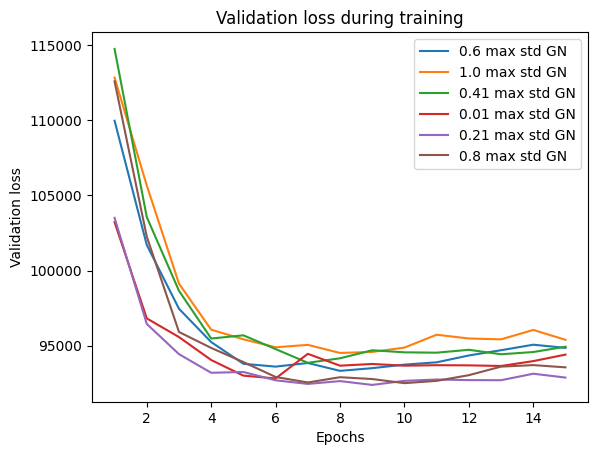

In [31]:
import matplotlib.pyplot as plt

epcs = all_losses[list(all_losses.keys())[0]]["epoch"]

for i in all_losses.keys():
    plt.plot(
        epcs,
        all_losses[i]["validation_loss"],
        label=str(dataset_names_max_var[i[:-10]]) + " max std GN",
    )

# Add labels, title, and legend
plt.xlabel("Epochs")
plt.ylabel("Validation loss")
plt.title("Validation loss during training")
plt.legend()

# Show the plot
plt.show()

### Analysing the latent space during with trained models

In [32]:
%pwd

'/Users/M283455/VAE_prject/notebooks'

In [33]:
%ls

Reconstruction_losses.ipynb     VAE_tybalt.ipynb
VAE_MNIST_data.ipynb            data_preprocessing.ipynb
VAE_tcga.ipynb                  runs/
VAE_train_genedata_noise.ipynb  tcga_rnaseq_df_0p1losses.csv
VAE_trining_with_3_data.ipynb
